STEP 1.Install and Import all the necessary libraries and environment check

In [35]:
!pip3 install torch torchvision

In [36]:
!nvidia-smi #check GPU

Sat Nov  9 06:09:02 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.216.01             Driver Version: 535.216.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:1E.0 Off |                    0 |
| N/A   33C    P0              32W /  70W |   3647MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [37]:
import torch
print("Using torch", torch.__version__)

Using torch 2.2.1+cu121


In [38]:
x = torch.rand(5, 3)
print(x)

tensor([[0.4835, 0.0220, 0.4677],
        [0.6716, 0.3949, 0.8558],
        [0.3917, 0.1964, 0.0040],
        [0.9966, 0.4648, 0.1547],
        [0.6731, 0.4190, 0.5973]])


In [39]:
import torchvision
print(torchvision.__version__)

0.17.1+cu121


In [40]:
if torch.cuda.is_available():
    device = torch.device('cuda')  # CUDA GPU
elif torch.backends.mps.is_available():
    device = torch.device('mps') #Apple GPU
else:
    device = torch.device("cpu")

In [41]:
print('Using device:', device)
#Additional Info when using cuda
if device.type == 'cuda':
    print("Device name: ", torch.cuda.get_device_name(0))
    print("Device properties:", torch.cuda.get_device_properties(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda
Device name:  Tesla T4
Device properties: _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15102MB, multi_processor_count=40)
Memory Usage:
Allocated: 0.4 GB
Cached:    3.4 GB


In [42]:
torch.cuda.device_count()

1

In [43]:
torch.version.cuda

'12.1'

In [44]:
!nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Mon_Apr__3_17:16:06_PDT_2023
Cuda compilation tools, release 12.1, V12.1.105
Build cuda_12.1.r12.1/compiler.32688072_0


In [45]:
torch.backends.cudnn.version()

8902

In [46]:
!echo $LD_LIBRARY_PATH

/opt/amazon/efa/lib:/opt/aws-ofi-nccl/lib:/usr/local/nvidia/lib:/usr/local/nvidia/lib64


In [47]:
torch.manual_seed(42) # Setting the seed

In [48]:
import zipfile
!pip install py7zr


Step2. Load the Dataset unzip and view the categories and preprocessing

In [49]:
import py7zr

archive_path = "Data.7z"
destination_folder = "images"

with py7zr.SevenZipFile(archive_path, mode='r') as archive:
    archive.extractall(path=destination_folder)

print(f"Extraction completed. Files are in {destination_folder}")

Extraction completed. Files are in images


In [50]:
import os

# List all files and directories in the current working directory
print("Current Working Directory:", os.getcwd())
print("Contents:", os.listdir(os.getcwd()))

Current Working Directory: /teamspace/studios/this_studio
Contents: ['.bashrc', '.cache', '.docker', '.idea', '.ipython', '.lightning_studio', '.lightningignore', '.sudo_as_admin_successful', '.vimrc', '.vscode', '.zcompdump', '.zsh_history', '.zshrc', 'DL_HW1.ipynb', 'Data.7z', 'examples', 'images', 'original_model.onnx', 'savedModel', 'scripted_model.onnx', '.jupyter', '.ssh', '.hushlogin', '.local', '.gitconfig', '.config', '.condarc', '.nv', '.oh-my-zsh', '.profile']


In [51]:

dataset_path = "/teamspace/studios/this_studio/images/Data"
# List all subfolders (categories) in the dataset
categories = os.listdir(dataset_path)

print(f"No of total categories : {len(categories)}")

# Initialize a dictionary to store the number of images in each category
image_counts = {}

# Loop through each category and count the images
for category in categories:
    category_path = os.path.join(dataset_path, category)

    if os.path.isdir(category_path): 
        # List all files in the category folder and filter out non-image files 
        image_files = [f for f in os.listdir(category_path) if f.endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif'))]
        image_counts[category] = len(image_files)

# Display the number of images in each category
for category, count in image_counts.items():
    print(f"Category: {category}, Number of images: {count}")







No of total categories : 102
Category: yin_yang, Number of images: 60
Category: flamingo_head, Number of images: 45
Category: llama, Number of images: 78
Category: chandelier, Number of images: 107
Category: schooner, Number of images: 63
Category: octopus, Number of images: 35
Category: pagoda, Number of images: 47
Category: stop_sign, Number of images: 64
Category: soccer_ball, Number of images: 64
Category: helicopter, Number of images: 88
Category: gerenuk, Number of images: 34
Category: pigeon, Number of images: 45
Category: Motorbikes, Number of images: 798
Category: butterfly, Number of images: 91
Category: umbrella, Number of images: 75
Category: laptop, Number of images: 81
Category: ketch, Number of images: 114
Category: crayfish, Number of images: 70
Category: tick, Number of images: 49
Category: cougar_body, Number of images: 47
Category: camera, Number of images: 50
Category: brontosaurus, Number of images: 43
Category: garfield, Number of images: 34
Category: cup, Number 

In [52]:
import shutil
from sklearn.model_selection import train_test_split


# Create directories for train and val sets under each category folder
for category in categories:
    os.makedirs(os.path.join(dataset_path, "train", category), exist_ok=True)
    os.makedirs(os.path.join(dataset_path, "val", category), exist_ok=True)

# Split images for each category into train and val
for category in categories:
    category_path = os.path.join(dataset_path, category)

    if os.path.isdir(category_path): 
        # Get all images in this category
        all_images = [os.path.join(category_path, f) for f in os.listdir(category_path) if f.endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif'))]

        # Split the images into train and val
        train_images, val_images = train_test_split(all_images, test_size=0.2, random_state=42)

        # Move images to the respective directories
        for img in train_images:
            shutil.move(img, os.path.join(dataset_path, "train", category, os.path.basename(img)))
        for img in val_images:
            shutil.move(img, os.path.join(dataset_path, "val", category, os.path.basename(img)))

print("Dataset has been split into train and val sets.")

Dataset has been split into train and val sets.


In [53]:
!pip install timm

In [54]:
import timm
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch import nn, optim
from torch.optim.lr_scheduler import StepLR
from timm.data import create_transform
from tqdm import tqdm  # For progress bar


In [55]:
# Data Augumentation ,the transformation with RandAugment
train_transform = create_transform(
    input_size=224,
    is_training=True,
    auto_augment='rand-m9-mstd0.5-inc1',  # RandAugment
)


# Transformation for validation (resize only)
val_transform = create_transform(
    input_size=224,
    is_training=False
)

In [56]:
# Define the paths for training and validation sets
train_dataset_path = os.path.join(dataset_path, "train")  
val_dataset_path = os.path.join(dataset_path, "val")

# Load datasets with augmentation for training and basic transforms for validation
train_dataset = datasets.ImageFolder(root=train_dataset_path, transform=train_transform)
val_dataset = datasets.ImageFolder(root=val_dataset_path, transform=val_transform)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

STEP3 - Define Model ,Loss function , optimizers and schedulers

In [57]:
# Load a pretrained model from timm
model = timm.create_model('resnet50', pretrained=True, num_classes=len(categories))
model = model.to("cuda" if torch.cuda.is_available() else "cpu")

In [58]:
# Define loss function
criterion = nn.CrossEntropyLoss()

# Define optimizer and learning rate scheduler
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)  # Decay LR by 0.1 every 10 epochs


STEP 4 - Model Training and Testing

In [59]:
num_epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_loss, val_loss, train_acc, val_acc = [], [], [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)

    # Validation
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_val_loss += loss.item()
            _, predicted = outputs.max(1)
            total_val += labels.size(0)
            correct_val += predicted.eq(labels).sum().item()

    val_loss.append(running_val_loss / len(val_loader))
    val_acc.append(100. * correct_val / total_val)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}, Val Loss: {val_loss[-1]:.4f}, Val Acc: {val_acc[-1]:.2f}")

    scheduler.step()


Training Epoch 1/20: 100%|██████████| 228/228 [01:29<00:00,  2.54it/s]


Epoch 1/20, Train Loss: 2.0455, Train Acc: 51.84, Val Loss: 0.5443, Val Acc: 82.14


Training Epoch 2/20: 100%|██████████| 228/228 [01:26<00:00,  2.65it/s]


Epoch 2/20, Train Loss: 1.0178, Train Acc: 73.20, Val Loss: 0.3804, Val Acc: 88.30


Training Epoch 3/20: 100%|██████████| 228/228 [01:25<00:00,  2.66it/s]


Epoch 3/20, Train Loss: 0.8557, Train Acc: 77.62, Val Loss: 0.3468, Val Acc: 89.38


Training Epoch 4/20: 100%|██████████| 228/228 [01:25<00:00,  2.66it/s]


Epoch 4/20, Train Loss: 0.7477, Train Acc: 79.57, Val Loss: 0.3172, Val Acc: 89.70


Training Epoch 5/20: 100%|██████████| 228/228 [01:25<00:00,  2.66it/s]


Epoch 5/20, Train Loss: 0.7133, Train Acc: 80.74, Val Loss: 0.3277, Val Acc: 88.73


Training Epoch 6/20: 100%|██████████| 228/228 [01:25<00:00,  2.67it/s]


Epoch 6/20, Train Loss: 0.6827, Train Acc: 81.28, Val Loss: 0.3282, Val Acc: 90.99


Training Epoch 7/20: 100%|██████████| 228/228 [01:25<00:00,  2.68it/s]


Epoch 7/20, Train Loss: 0.6362, Train Acc: 82.80, Val Loss: 0.3106, Val Acc: 91.26


Training Epoch 8/20: 100%|██████████| 228/228 [01:25<00:00,  2.67it/s]


Epoch 8/20, Train Loss: 0.5923, Train Acc: 84.09, Val Loss: 0.3073, Val Acc: 91.26


Training Epoch 9/20: 100%|██████████| 228/228 [01:25<00:00,  2.67it/s]


Epoch 9/20, Train Loss: 0.5766, Train Acc: 84.24, Val Loss: 0.2914, Val Acc: 91.15


Training Epoch 10/20: 100%|██████████| 228/228 [01:25<00:00,  2.67it/s]


Epoch 10/20, Train Loss: 0.5601, Train Acc: 84.82, Val Loss: 0.2927, Val Acc: 91.85


Training Epoch 11/20: 100%|██████████| 228/228 [01:25<00:00,  2.68it/s]


Epoch 11/20, Train Loss: 0.4744, Train Acc: 86.98, Val Loss: 0.2301, Val Acc: 93.62


Training Epoch 12/20: 100%|██████████| 228/228 [01:25<00:00,  2.68it/s]


Epoch 12/20, Train Loss: 0.4044, Train Acc: 88.63, Val Loss: 0.2213, Val Acc: 93.51


Training Epoch 13/20: 100%|██████████| 228/228 [01:25<00:00,  2.68it/s]


Epoch 13/20, Train Loss: 0.3860, Train Acc: 89.34, Val Loss: 0.2074, Val Acc: 94.05


Training Epoch 14/20: 100%|██████████| 228/228 [01:25<00:00,  2.66it/s]


Epoch 14/20, Train Loss: 0.3674, Train Acc: 89.88, Val Loss: 0.2211, Val Acc: 93.67


Training Epoch 15/20: 100%|██████████| 228/228 [01:25<00:00,  2.66it/s]


Epoch 15/20, Train Loss: 0.3534, Train Acc: 90.44, Val Loss: 0.2087, Val Acc: 93.62


Training Epoch 16/20: 100%|██████████| 228/228 [01:25<00:00,  2.68it/s]


Epoch 16/20, Train Loss: 0.3638, Train Acc: 89.99, Val Loss: 0.2175, Val Acc: 94.05


Training Epoch 17/20: 100%|██████████| 228/228 [01:25<00:00,  2.66it/s]


Epoch 17/20, Train Loss: 0.3103, Train Acc: 91.24, Val Loss: 0.2101, Val Acc: 94.31


Training Epoch 18/20: 100%|██████████| 228/228 [01:25<00:00,  2.67it/s]


Epoch 18/20, Train Loss: 0.3175, Train Acc: 91.21, Val Loss: 0.2064, Val Acc: 94.15


Training Epoch 19/20: 100%|██████████| 228/228 [01:25<00:00,  2.66it/s]


Epoch 19/20, Train Loss: 0.3238, Train Acc: 90.76, Val Loss: 0.2064, Val Acc: 93.78


Training Epoch 20/20: 100%|██████████| 228/228 [01:25<00:00,  2.65it/s]


Epoch 20/20, Train Loss: 0.3206, Train Acc: 90.85, Val Loss: 0.2042, Val Acc: 93.94


STEP 5 - Plot Loss and accuracy over epochs

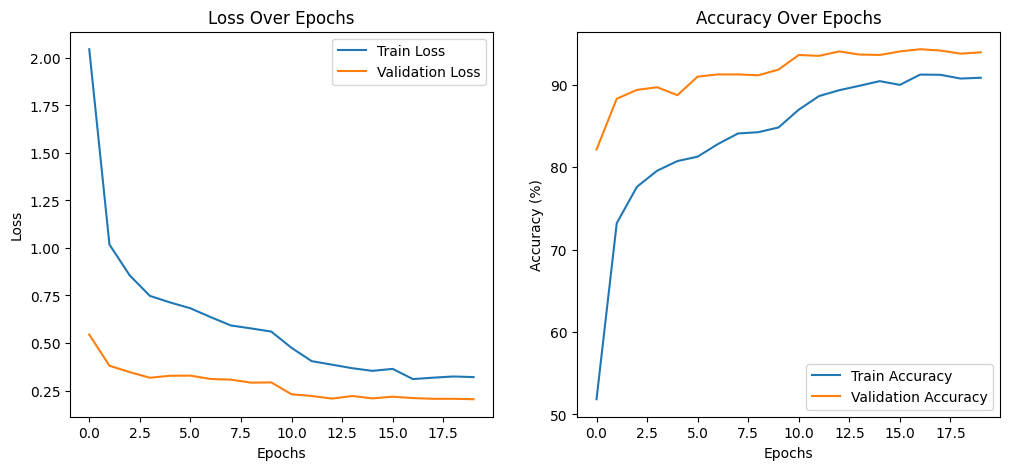

Average Inference Latency: 5.90 ms


In [60]:
# Plot accuracy and loss over epochs
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.show()

# Check latency (inference time)
import time
sample_input = torch.rand(1, 3, 224, 224).to(device)
model.eval()
with torch.no_grad():
    start_time = time.time()
    for _ in range(100):
        _ = model(sample_input)
    latency = (time.time() - start_time) / 100  # Average over 100 runs
print(f"Average Inference Latency: {latency * 1000:.2f} ms")


optimized in data loaders to check accuracy changes/improvement adding number of workers and pin-memory

In [61]:
from torch.cuda.amp import autocast
use_amp = True 

#  **Use of Optimized DataLoader**
# Increase num_workers for parallel data loading
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

# Use torch.no_grad() to avoid unnecessary computation of gradients during inference
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
        inputs, labels = inputs.to(device), labels.to(device)

        # Mixed precision inference
        with autocast(enabled=use_amp):  
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)

    # Validation
    model.eval()  # Set to evaluation mode to disable dropout/batchnorm
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    # Disable gradient calculation for validation
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Mixed precision inference 
            with autocast(enabled=use_amp):
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            running_val_loss += loss.item()
            _, predicted = outputs.max(1)
            total_val += labels.size(0)
            correct_val += predicted.eq(labels).sum().item()

    val_loss.append(running_val_loss / len(val_loader))
    val_acc.append(100. * correct_val / total_val)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}, Val Loss: {val_loss[-1]:.4f}, Val Acc: {val_acc[-1]:.2f}")

    scheduler.step()



Training Epoch 1/20: 100%|██████████| 228/228 [00:27<00:00,  8.26it/s]


Epoch 1/20, Train Loss: 0.3215, Train Acc: 90.93, Val Loss: 0.2008, Val Acc: 93.99


Training Epoch 2/20: 100%|██████████| 228/228 [00:27<00:00,  8.24it/s]


Epoch 2/20, Train Loss: 0.3147, Train Acc: 91.26, Val Loss: 0.2001, Val Acc: 94.21


Training Epoch 3/20: 100%|██████████| 228/228 [00:27<00:00,  8.23it/s]


Epoch 3/20, Train Loss: 0.2895, Train Acc: 92.06, Val Loss: 0.1948, Val Acc: 94.21


Training Epoch 4/20: 100%|██████████| 228/228 [00:27<00:00,  8.21it/s]


Epoch 4/20, Train Loss: 0.3017, Train Acc: 91.76, Val Loss: 0.1985, Val Acc: 93.83


Training Epoch 5/20: 100%|██████████| 228/228 [00:27<00:00,  8.21it/s]


Epoch 5/20, Train Loss: 0.3054, Train Acc: 91.25, Val Loss: 0.1954, Val Acc: 94.05


Training Epoch 6/20: 100%|██████████| 228/228 [00:27<00:00,  8.23it/s]


Epoch 6/20, Train Loss: 0.3061, Train Acc: 91.52, Val Loss: 0.1938, Val Acc: 94.21


Training Epoch 7/20: 100%|██████████| 228/228 [00:27<00:00,  8.23it/s]


Epoch 7/20, Train Loss: 0.3173, Train Acc: 91.28, Val Loss: 0.1943, Val Acc: 94.05


Training Epoch 8/20: 100%|██████████| 228/228 [00:27<00:00,  8.23it/s]


Epoch 8/20, Train Loss: 0.3143, Train Acc: 91.54, Val Loss: 0.1888, Val Acc: 94.15


Training Epoch 9/20: 100%|██████████| 228/228 [00:27<00:00,  8.23it/s]


Epoch 9/20, Train Loss: 0.2932, Train Acc: 91.50, Val Loss: 0.1896, Val Acc: 94.26


Training Epoch 10/20: 100%|██████████| 228/228 [00:27<00:00,  8.21it/s]


Epoch 10/20, Train Loss: 0.3099, Train Acc: 91.61, Val Loss: 0.1894, Val Acc: 94.37


Training Epoch 11/20: 100%|██████████| 228/228 [00:27<00:00,  8.22it/s]


Epoch 11/20, Train Loss: 0.2888, Train Acc: 91.74, Val Loss: 0.1952, Val Acc: 94.10


Training Epoch 12/20: 100%|██████████| 228/228 [00:27<00:00,  8.21it/s]


Epoch 12/20, Train Loss: 0.3059, Train Acc: 91.47, Val Loss: 0.1947, Val Acc: 94.37


Training Epoch 13/20: 100%|██████████| 228/228 [00:27<00:00,  8.20it/s]


Epoch 13/20, Train Loss: 0.2986, Train Acc: 91.65, Val Loss: 0.1948, Val Acc: 94.37


Training Epoch 14/20: 100%|██████████| 228/228 [00:27<00:00,  8.21it/s]


Epoch 14/20, Train Loss: 0.2857, Train Acc: 91.92, Val Loss: 0.1903, Val Acc: 94.53


Training Epoch 15/20: 100%|██████████| 228/228 [00:27<00:00,  8.23it/s]


Epoch 15/20, Train Loss: 0.3012, Train Acc: 91.90, Val Loss: 0.1949, Val Acc: 94.26


Training Epoch 16/20: 100%|██████████| 228/228 [00:27<00:00,  8.22it/s]


Epoch 16/20, Train Loss: 0.2863, Train Acc: 92.17, Val Loss: 0.1987, Val Acc: 94.21


Training Epoch 17/20: 100%|██████████| 228/228 [00:27<00:00,  8.22it/s]


Epoch 17/20, Train Loss: 0.2987, Train Acc: 91.73, Val Loss: 0.1969, Val Acc: 94.10


Training Epoch 18/20: 100%|██████████| 228/228 [00:27<00:00,  8.22it/s]


Epoch 18/20, Train Loss: 0.2802, Train Acc: 91.91, Val Loss: 0.1931, Val Acc: 94.21


Training Epoch 19/20: 100%|██████████| 228/228 [00:27<00:00,  8.22it/s]


Epoch 19/20, Train Loss: 0.2816, Train Acc: 91.87, Val Loss: 0.1936, Val Acc: 94.37


Training Epoch 20/20: 100%|██████████| 228/228 [00:27<00:00,  8.21it/s]


Epoch 20/20, Train Loss: 0.3053, Train Acc: 91.66, Val Loss: 0.1938, Val Acc: 94.10


Replotting the accuracy and Loss over epochs

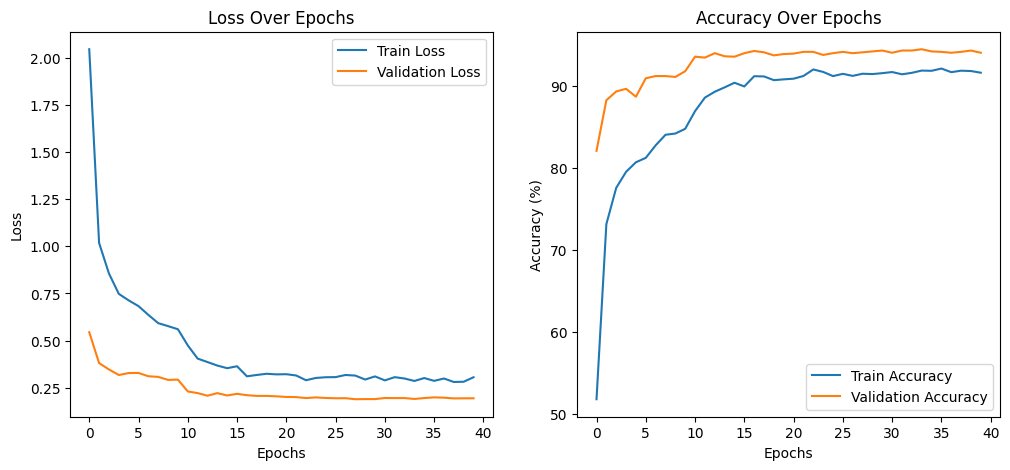

Average Inference Latency after using optimized data loaders: 5.86 ms


In [62]:
import matplotlib.pyplot as plt
# RePlot accuracy and loss over epochs
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.show()

# Check latency (inference time)
import time
sample_input = torch.rand(1, 3, 224, 224).to(device)
model.eval()
with torch.no_grad():
    start_time = time.time()
    for _ in range(100):
        _ = model(sample_input)
    latency = (time.time() - start_time) / 100  # Average over 100 runs
print(f"Average Inference Latency after using optimized data loaders: {latency * 1000:.2f} ms")


Step 6.Save the Model

In [63]:
os.makedirs('savedModel', exist_ok=True)
filename=os.path.join('savedModel', 'modelcheckpoint.pth.tar')
torch.save(model.state_dict(), filename)

Model Export , Scripting and Inference optimization

In [64]:
!pip install onnx onnxruntime
import torch.onnx
import numpy as np


# Set model to evaluation mode
model.eval()  

# Prepare a dummy input tensor for export and latency measurement
device = 'cuda' if torch.cuda.is_available() else 'cpu'
dummy_input = torch.randn(1, 3, 224, 224).to(device)

#  Export Original Model to ONNX
torch.onnx.export(
    model,                   
    dummy_input,             
    "original_model.onnx",  
    export_params=True,      
    opset_version=10,         
    do_constant_folding=True, 
    input_names=['input'],    
    output_names=['output'],  
    dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}  
)
print("Original model exported to original_model.onnx")

#  Script the Model it is to  Convert to TorchScript
scripted_model = torch.jit.script(model)  

#  Export Scripted Model to ONNX
torch.onnx.export(
    scripted_model,              
    dummy_input,                  
    "scripted_model.onnx",       
    export_params=True,          
    opset_version=10,            
    do_constant_folding=True,    
    input_names=['input'],        
    output_names=['output'],      
    dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}  
)
print("Scripted model exported to scripted_model.onnx")

# Average Latency

def compute_latency(model, dummy_input, num_runs=100):
    latencies = []
    with torch.no_grad():
        for _ in range(num_runs):
            start_time = time.time()
            _ = model(dummy_input)
            end_time = time.time()
            latencies.append((end_time - start_time) * 1000)  # latency in ms
    return np.mean(latencies)

# Move models to the device
model.to(device)
scripted_model.to(device)

# Measure latency for original and scripted models
num_runs = 100
original_latency = compute_latency(model, dummy_input, num_runs)
scripted_latency = compute_latency(scripted_model, dummy_input, num_runs)

# Calculate speedup
speedup = original_latency / scripted_latency

print(f"Average latency for original model: {original_latency:.2f} ms")
print(f"Average latency for scripted model: {scripted_latency:.2f} ms")
print(f"Speedup: {speedup:.2f}x")


Original model exported to original_model.onnx
Scripted model exported to scripted_model.onnx
Average latency for original model: 5.98 ms
Average latency for scripted model: 4.10 ms
Speedup: 1.46x
